## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR)

In [6]:
# graph setting
sns.set()

## 混合モデル

In [7]:
os.makedirs("data",exist_ok=True)
urlretrieve("https://git.io/vXt6b","data/mixture.csv")

('data/mixture.csv', <http.client.HTTPMessage at 0x7f32a74acfd0>)

In [8]:
df=pd.read_csv("./data/mixture.csv",header=None)
data=df.values[:,0]
data = np.loadtxt("data/mixture.csv", delimiter=",")

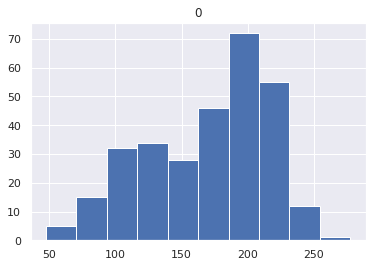

In [9]:
df.hist();

In [10]:
with pm.Model() as model:
    p1=pm.Uniform("p",0,1)
    p2=1-p1
    p=tt.stack([p1,p2])
    assignment=pm.Categorical("assignment",p,
                             shape=data.shape[0],
                             testval=np.random.randint(0,2,data.shape[0]))

In [11]:
with model:
    sds=pm.Uniform("sds",0,100,shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment]) 
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)

In [12]:
with model:
    step1=pm.Metropolis(vars=[p,sds,centers])
    step2=pm.ElemwiseCategorical(vars=[assignment])
    trace=pm.sample(1000,step=[step1,step2],return_inferencedata=False)

<ipython-input-12-f2fe7c9f2551>:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step2=pm.ElemwiseCategorical(vars=[assignment])
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>CompoundStep
INFO:pymc3:>CompoundStep
>>Metropolis: [centers]
INFO:pymc3:>>Metropolis: [centers]
>>Metropolis: [sds]
INFO:pymc3:>>Metropolis: [sds]
>>Metropolis: [p]
INFO:pymc3:>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
INFO:pymc3:>ElemwiseCategorical: [assignment]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
/workspaces/load_to_goal/GitHub/bayesian_statistics/.venv/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


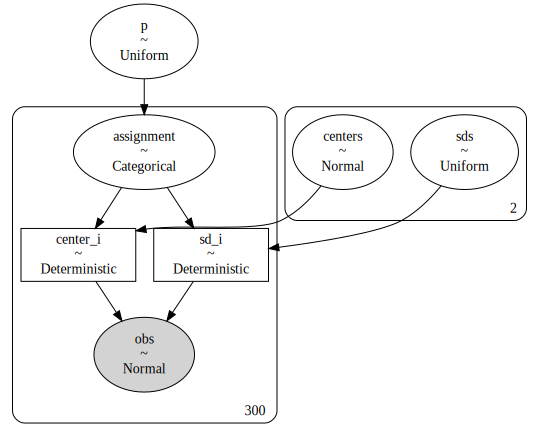

In [19]:
pm.model_to_graphviz(model)

In [13]:
center_trace=trace["centers"]

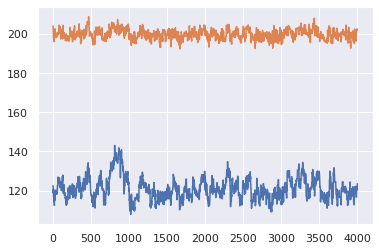

In [14]:
plt.plot(center_trace[:,0])
plt.plot(center_trace[:,1])

In [15]:
assignment_trace=trace["assignment"]

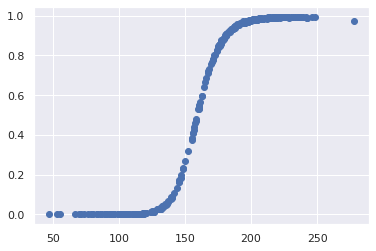

In [16]:
plt.scatter(data,assignment_trace.mean(axis=0))

## plot

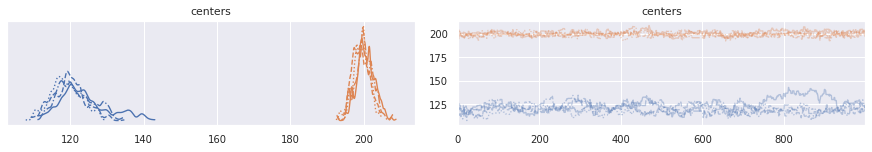

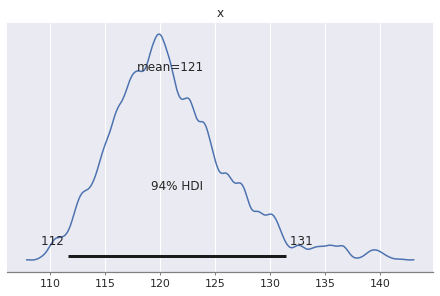

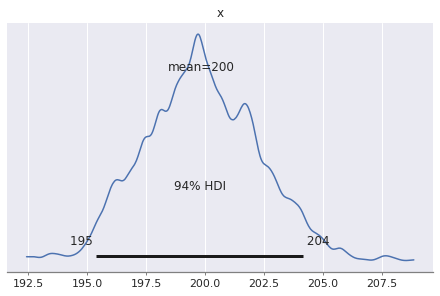

In [18]:
with model:
    az.plot_trace(trace, var_names=["centers"])
    az.plot_posterior(trace["centers"][:,0])
    az.plot_posterior(trace["centers"][:,1])